# Setup

1. Setup matplotlib
1. Setup the path
1. Load in libraries
1. Load in theano and keras

In [1]:
%matplotlib inline

In [2]:
path = "data/dogscatsredux/"

In [3]:
#Other imports
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

#Import the utils library from class (need it for plotting at the end)
import utils; reload(utils)
from utils import plots

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [4]:
#Keras imports


import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

# Data preparation

Download from VGG all prepared models + weights and save them to the models folder.

In [5]:
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
# Keras' get_file() is a handy function that downloads files, and caches them for re-use later
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: class_dict = json.load(f)
# Convert dictionary with string indexes into an array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [6]:
#To ensure we loaded classes classes correctly, let's output the first few
classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

# Model Creation

In order to create the model, we need to define two types of blocks (layers?) - convolutional and "dense". At the time of this writing I have limited understanding of these blocks.

I *believe* that convolutional blocks are looped back to itself for reinforcement, but am not sure - I'm gathering that from reading other sources. "Dense" blocks are also called "Fully connected" blocks in that they connect to everything else layer wise.

In [7]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

Here is the documentation for the functions and data items used above, and my brief understanding of each.

## [ZeroPadding2D](https://keras.io/layers/convolutional/#zeropadding2d)

Only argument is padding, which specifies size of returned block. It adds rows and columns of zeros to an image tensor.

Apparently the padding is applied primarily because applying operations (stride + padding w/ kernel) results in a smaller output size. Adding padding gets us to the desired output size without modifying the data (see more [here](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/)).

##  [Convolution2D](https://keras.io/layers/convolutional/#conv2d)

Arguments are: filters, kernel_size, strides, padding, activation (and more)

### filters

An integer representing the number of filters in the convolution.

### kernel_size

An integer (or tuple/list, but in this case integer) that specifies the width/height (square can be integer) of the convolution window. In this example, we are doing 3x3.

### strides

Tuple/list of 2 #s or a single integer representing width/height. Specifies "strides" of the convolution along width/height. Not sure at all what this does ATM.

### activation

Type of activation function to use. If none specified, it defauts to linear. [Here is the list of activation functions available](https://keras.io/activations/). `relu` (short for [Rectified Linear Unit](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))) fires the follow functionality internally:

```
relu(x, alpha=0.0, max_value=None)
```

To me this seems like the actual functional activation of a given neuron in a neural network?

## [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d)

Defines pooling size and strides, but am unsure what pooling does ATM.

Update found an explanation on [this site](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/):

```
After some ReLU layers, programmers may choose to apply a pooling layer. It is also referred to as a downsampling layer. In this category, there are also several layer options, with maxpooling being the most popular. This basically takes a filter (normally of size 2x2) and a stride of the same length. It then applies it to the input volume and outputs the maximum number in every subregion that the filter convolves around.
 ```
 
![Max pooling explanation](https://adeshpande3.github.io/assets/MaxPool.png)

In [8]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

Here are the two functions used herein.

## [Dense](https://keras.io/layers/core/#dense)

This creates a "dense" neuron, which is fully connected to all prior layers of the network. Arguments are units and activation.

We picked "1000" here I believe because there are 1000 possible categories/labels within the trained VGG network.

### units
This is the "dimensionality" of the space - I'm guessing that it's the result of the width multiplied by the height

### activation
Read above about in the Convultional2D function explanation "relu" activation

## [Dropout](https://keras.io/layers/core/#dropout)

`Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting.`

Argument is rate - should be a float between 0 and 1. Additional options are unused but exist to increase noise and randomness in the network.


# VGG Creation

We are now going to use the convolutional and dense blocks to recreate VGG.

First we have to define a vgg_mean function, which is going to use magic #'s provided by the VGG researchers. I am unsure as to their meaning.

In [9]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

Taking this mean, we will subtract it from the data giving a resulting mean of zero.

Then we need to create a preprocess function. This is because the data + python is using RGB by default, whereas their software is assuming BGR, so we need to re-order incoming data.

In [10]:
def vgg_preprocess(x):
    x = x - vgg_mean #subtract the mean
    return x[:, ::-1] # reverse

Now we have to recreate the VGG architecture. There was VGG_16 and VGG_19 - 19 is slightly more accurate but far slower, so we're recreating VGG_16. I suspect the #'s are iteration numbers.

When we create the neural network, we're adding convolution layers for finding patterns in images, and dense layers for combining patterns across images.

In [21]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,244,244)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    
    return model

## [Sequential](https://keras.io/getting-started/sequential-model-guide/)

A linear stack of layers, one after another. You can either pass an array of layers on the instantiation or call .add() as we have.

## [Lambda](https://keras.io/layers/core/#lambda)

Given an arbitrary function, create a layer object out of it.

Therefore, in our usage, we are calling vgg_preprocess for each piece of data prior to passing it into the rest of our NN, therefore subtracting the researcher provided mean and reversing the order of data to BGR.

## [Flatten](https://keras.io/layers/core/#flatten)

Flattens the input. Based on the example in the documentation it seems like it is multiplying it through, but am unsure why. 

In [12]:
#Instantiate our model

model = VGG_16()

We're going to download the weights the VGG creators trained to start from. Without the weights this would take days.

In [13]:
fpath = get_file('vgg16.h5', FILES_PATH + 'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

At this point, model is a model object of Keras, specifically a `Sequential` model, so we have all the helper functions attached to that. Hence the load_weights functionality.

In [14]:
# Use this to read the dosc on model and see what it has
?model

# Getting Imagenet Predictions

We have created the imagenet model above. We now grab images in batches and call `predict()` on them.

In [15]:
batch_size = 4

def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

The get_batches function is designed to simplify the grabbing of images from a given directory and batching them together for us. This will include whether or not to shuffle the data, the size of the batch (defaulting to our aforementioned defined batch size), and the class mode. This is passed through to `gen.flow_from_directory`.

### gen

gen is passed in and is of type [ImageDataGenerator](https://keras.io/preprocessing/image/), which is a helper class to deal with image data for Keras. 

### flow_from_directory

Taken from above-linked documentation:
`flow_from_directory(directory): Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.`

In this function we are defining the path, the target size image to resize to, the batch size, the class mode, and whether or not to shuffle.

The class mode can be `categorical`, `binary`, `sparse`, or `None`. Categorical will be 2d hot-encoded labels, binary will be 1D binary labels, sparse will be 1D integer values, and None will create no labels.

Found 25000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


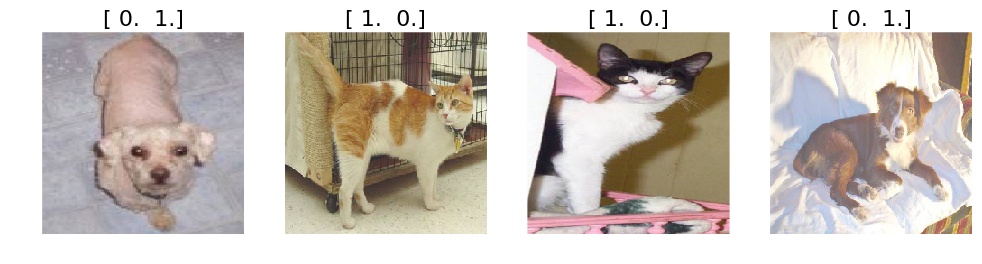

In [16]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs, labels = next(batches)

#Shows the 'truth'
plots(imgs, titles=labels)

The VGG model we just created returns 1000 probabilities for each image - a probability of each known category (breed of dog, for instance, fish, cat, etc). We need to find the largest probability in that image. 

In [17]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    print(preds)
    idxs = np.argmax(preds, axis=1) #1 axis cause it's just array of category labels
    
    print('Shape: {}'.format(preds.shape)) #shape of the predictions
    print('First 5 classes: {}'.format(classes[:5])) #First 5 classes
    print('First 5 probabilities: {}'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [18]:
print(imgs.shape)

(4, 3, 224, 224)


In [19]:
pred_batch(imgs)

Exception: Error when checking : expected lambda_input_1 to have shape (None, 3, 244, 244) but got array with shape (4, 3, 224, 224)

## Error encountered above:

```
Exception: Error when checking : expected lambda_input_2 to have shape (None, 3, 244, 244) but got array with shape (4, 3, 224, 224)
```

This is the error I encountered on first run through. The array being passed in w/ shape (4, 3, 224, 224) matches that of the lesson example, so that seems right to me. The 4 is linked to the batch_size variable, so it's the number of images being passed in. For some reason, it detects `None` images? Looking into it.

I then encountered this [thread](http://forums.fast.ai/t/error-when-trying-to-fit-vgg-expected-lambda-input-2-to-have-shape-none-3-224-224-but-got-array-with-shape-16-224-224-3/3386/4), with a similar problem.

One person suggested setting argument `dim_order="th"` on the ImageDataGenerator, which did not work. The other suggestion, to sue `data_format=":channels_first"` didn't work as it seems that is a Keras 2.0 feature (checking pip revealed Keras 1.1 for this course).

*Update that night 9/3/2017*

After more thinking, I don't think that the above thread has anything to do with the problem. My data is not reversed as their examples are. The `lambda_input_2` name is what's getting assigned to the Lambda function when creating the model - executing that increments the lambda function identifier (ie `lambda_input_3`, etc).

I tried setting batch_size directly on the predict function call, but that doesn't seem to work. I'm unsure if this is because of a bad data set that Keras is expecting (starting to feel likely) or if there is still a problem with the batch_size being passed through.

If it is the data, however, I am a bit confused as to why I'm passing in the img data then.


*Update the next night 9/4/2017*

I have a thread going on the help forum. Hopefully I can be helped there...
